## Etape 2 : Statistiques descriptives

### Import des librairies et analyse du jeu de données

Import des différentes librairies utiles à l'analyse :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
import time
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import gender_guesser.detector as gender

Il est nécessaire d'installer et d'importer "importnb" pour avoir accès aux fonctionns définies dans "algoStatCourse" ainsi que gender guesser.

In [2]:
#pip install importnb
#!pip install gender-guesser

In [2]:
from importnb import Notebook
with Notebook():
    import algoStatCourse

Il faut ensuite importer un jeu de données. On prend le jeu de données correspondant à un marathon comme exemple pour l'analyse dans ce document.

In [73]:
#data=pd.read_csv("10_km_Riorges.csv")

In [3]:
data=pd.read_csv("data/France2022_MARATHON_TC.csv")

Comme chaque jeu de données extrait, nous avons à notre disponibilité la performance de chaque athlète, leur ligue, leur année de naissance, la catégorie à laquelle ils appartiennent, leur temps, ainsi que leur écart de temps avec le premier.

In [5]:
data.head()

,Athlète,Ligue,Performance,Naissance,Catégorie,hours,minutes,seconds,time_delta,time_gap,duration
0,KOMEN Titus Kirwa,I-F,D7,1976,M2F,2,16,19,0 days 02:16:19,0 days 00:00:00,8179.0
1,HRIOUED Alaa,ARA,N2,1985,M0M,2,16,37,0 days 02:16:37,0 days 00:00:18,8197.0
2,PERRILLAT Duncan,I-F,N2,1993,SEM,2,17,41,0 days 02:17:41,0 days 00:01:22,8261.0
3,OLIVIER Aurelien,I-F,N2,1993,SEM,2,17,45,0 days 02:17:45,0 days 00:01:26,8265.0
4,BRIAND Gabriel,ARA,N2,1995,SEM,2,18,27,0 days 02:18:27,0 days 00:02:08,8307.0


On extrait le nom et prénom afin que ce soit plus pratique et plus consistant pour les recherches individuelles.

In [4]:
data['Prénom'] = data['Athlète'].str.extract('[A-Z]+(?:[- ]?[A-Z]+)? (.+)')
data['Nom'] = data.apply(lambda row: row['Athlète'].replace(row['Prénom'], ''), axis=1)

On ajoute la variable 'h_duration' qui permet d'obtenir le temps d'arrivée dans le format heures, minutes, secondes, afin d'avoir une variable explicite pour la visualisation.

In [18]:
data['h_duration'] = data['duration'].apply(lambda x : pd.to_datetime(x,unit="s").strftime('%H:%M:%S'))

Nous analysons maintenant les statistiques descriptives du temps d'arrivée afin de connaitre rapidement la forme des données, et la présence de possible valeurs abérantes, pour guider la construction des visualisations utile à l'athlète. Dans ce jeu de données, nous n'avons à première vue pas de potentiels valeurs abbérantes étant donnés que les temps sont compris dans un intervalle standard pour un marathon.

In [9]:
(data['duration']/60).describe()

count    2270.000000
mean      224.457724
std        38.978157
min       136.316667
25%       195.308333
50%       222.450000
75%       249.258333
max       337.700000
Name: duration, dtype: float64

### Construction des visualisations et données utiles à l'athlète

On définit une fonction qui permet d'appliquer une indicatrice afin de retourner la partie de la fonction qui nous intéresse. Cela sera utile pour mettre en avant les athlètes plus rapides qu'un athlète donné dans la distribution des temps.

In [5]:
def truncf (f,xmin, xmax):
    def f2 (x):
        if (x>=xmin)*(x<=xmax):
            return f(x)
        return np.nan
    
    return np.vectorize(f2)

Il est maintenant possible de définir une fonction pour visualiser la position individuelle de l'athlète dans la densité de temps de la compétition. On utilise 'algoStatCourse' pour construire un graphique rendant compte de la position de l'athlète dans la densité des temps d'arrivée.

In [8]:
def graphePerso(prenom, nom, data, titre):
    
    densite=algoStatCourse.dens(data['duration'], bins = algoStatCourse.idealBins(len(data['duration']))) #Calcul de la densité de la variable 'duration'
    #print(densite)
    fcubic=algoStatCourse.lissage(densite, sep = True,beginend = (data['duration'].min(),data['duration'].max())) #Retourne la fonction d'interpolation cubique
    flin=algoStatCourse.lissage(densite, sep = False, kind = 'linear', beginend = (data['duration'].min(),data['duration'].max())) #Retourne la fonction d'interpolation linéaire
    
    z=data.index[data.Athlète==(nom.upper()+" "+prenom.capitalize())] #numéro de l'index du participant
    
    temps = data.loc[z[0],'duration'] #temps du participant
    
    x= np.linspace(data['duration'].min(),data['duration'].max(), int(1e5)) #x permet d'obtenir un tracé continu

    tempsAxe = np.linspace(densite[0,0],densite[0,-1],6) #définition de l'axe des abscisses en secondes avec 6 points
    labelTempsAxe = pd.Series(tempsAxe).apply(lambda x : pd.to_datetime(x,unit="s").strftime('%H:%M:%S')) #Définition de la forme que prendra le temps sur l'axe des abcisses (format heures/minutes/secondes pour plus de lisibilité)

    plt.figure(figsize=(8,4.5), dpi=80) #format de la figure, (dpi pour la résolution)
    plt.fill_between(x, fcubic(x), alpha = 0.3) #fonction pour colorier l'aire sous la courbe
    plt.plot(x, fcubic(x), color = 'blue', label = 'densité lissée & interpolée')

    #plt.plot(x,flin(x), linestyle ='--', color = 'black', label = "densité réelle") #possibilité de dessiner l'interpolation linéaire au lieu de l'interpolation cubique

    plt.axvline(temps, color='r',alpha=0.3) #ligne verticale pour indiquer la position du participant sur les abscisses

    f2=truncf(fcubic,data['duration'].min(), temps) #on tronque fcubic pour ne retenir que la partie de la fonction des temps meilleurs à celui de l'individu
    plt.fill_between(x,f2(x), alpha = 0.6, color = 'red') #on affiche l'aire des temps meilleurs à celui de l'individu en rouge

    #plt.axvspan(temps, densite[0,0], color='r', alpha=0.3)
    plt.legend() #permet d'afficher les légendes qu'on a mises dans les arguments 'label' des fonctions juste au dessus

    # Ajout des labels et titre
    plt.title(titre, color= 'tab:red', fontsize = '15', fontstyle = 'oblique') # titre
    plt.xlabel("Durée pour franchir la ligne d'arrivée", fontstyle = 'italic', labelpad=5) #label abscisse
    plt.ylabel("Densité des athlètes", fontstyle = 'italic', labelpad=20) #label ordonnée
    plt.xticks(tempsAxe,labels = labelTempsAxe) #permet de choisir ce qu'on met sur l'axe des x : les coordonnées dans le premier argument, ce qu'il faut afficher dans le second.
    plt.ylim((-0.1*max(densite[1]),1.1*max(densite[1]))) #permet de choisir l'espace au dessus et au dessous du graphe
    plt.text(data.loc[z[0],'duration'],0.0001,data.loc[z[0],'Prénom'] ) # ajoute un texte directement sur le graphe
    plt.show()
    return

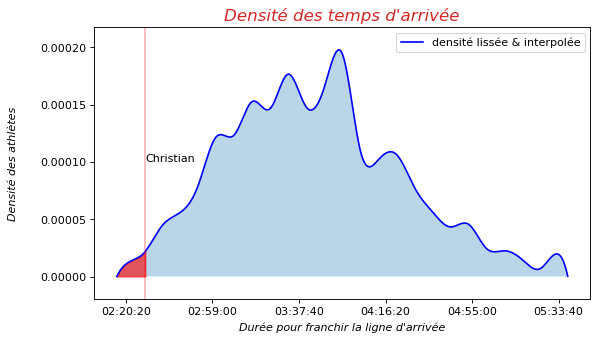

In [9]:
graphePerso("christian","drean", data=data,titre = "Densité des temps d'arrivée")

On teste maintenant la fonction graphePerso en se restreignant à la catégorie de l'athlète. Cependant, certaines catégories peuvent acceuillir très peu de participants, voire qu'un seul participant. Dans ce cas. la visualisation peut-être biaisée ou même impossible à construire. On se restreindra aux catégories qui accueuillent un certain nombre de participants dans la suite de l'analyse. Ci-dessous le nombre d'athlète par catégorie.

In [14]:
data.groupby('Catégorie').count().iloc[:,1]

Catégorie
ESF      1
ESM      8
M0F     69
M0M    206
M1F     80
M1M    344
M2F     90
M2M    317
M3F     89
M3M    295
M4F     36
M4M    194
M5F     16
M5M     93
M6F      7
M6M     28
M7F      5
M7M     17
M8M      7
SEF     71
SEM    279
Name: Ligue, dtype: int64

On utilise la fonction 'graphePerso' pour construire 'graphePerso2'en se restreignant à la catégorie de l'atthlète étudié.

In [10]:
def graphePerso2(prenom, nom, data=data):
    z=data.index[data.Athlète==(nom.upper()+" "+prenom.capitalize())]
    data2=data[data['Catégorie']==data.loc[z[0],'Catégorie']]
    graphePerso(prenom, nom, data=data2, titre = f"Densité des temps d'arrivée dans la catégorie {data.loc[z[0],'Catégorie']}")
               
    return

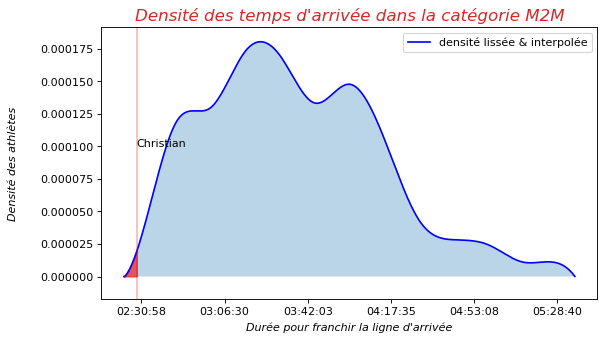

In [11]:
graphePerso2("christian","drean", data=data)

### Construction et application de l'output des statistiques et visuels individuels

On construit d'abord deux fonctions qui permettront de demander à l'utilisateur son nom et prénom.

In [15]:
def Prenom():
  user_input = input("Veuillez entrer votre prénom")
  return user_input

def Nom():
  user_input = input("Veuillez entrer votre nom")
  return user_input

Ici, on définit une fonction permettant de donner directement les premières informations utile, à partir du nom et prénom, de la performance individuelle relativement à la performance globale de la compétition, notamment grâce aux visuels construit plus haut. 

In [16]:
def info_participant():
    x= Prenom()
    y= Nom()
    if ~data['Athlète'].isin([(y.upper()+" "+x.capitalize())]).any():
        print("Le nom que vous avez entré n'est pas dans la liste des participants de la course choisie.")
    else:
        z=data.index[data.Athlète==(y.upper()+" "+x.capitalize())]
        print("Temps d'arrivé :", data.loc[z[0],'h_duration'])
        print("Position d'arrivée : ", data.index[z[0]]+1)
        print("Niveau de la performance", data.loc[z[0],'Performance'])
        print("Temps d'arrivé dans le top :", math.ceil(((data.duration<=data.loc[z[0],'duration']).sum())/len(data)*100),"%")
        print("Position parmis les", len(data[data['Catégorie']==data.loc[z[0],'Catégorie']]),"participants de la catégorie", data.loc[z[0],'Catégorie'], ":",round(data[data['Catégorie']==data.loc[z[0],'Catégorie']]['duration'].rank().loc[z[0]]))
        print("Position parmis les", len((data[abs(data.loc[:,'Naissance']-data.loc[z[0],'Naissance'])<=5])), "participants ayant plus ou moins 5 ans de différence d'âge avec vous : ", round(((data[abs(data.loc[:,'Naissance']-data.loc[z[0],'Naissance'])<=5])['duration'].rank()).loc[z[0]]))
        graphePerso(x,y,data,titre="Durée pour franchir la ligne d'arrivée")
        if len(data[data['Catégorie']==data.loc[z[0],'Catégorie']])>10:#la fonction graphPerso 2 ne se lance que si il y a un certains nombre d'athlète inscrit dans la catégorie
            graphePerso2(x,y,data)

Exemple d'utilisation:

In [ ]:
info_participant()

### Information sur la compétition

On construit maintenant un tableau des podiums par catégorie. Ce type d'information est utile à l'athlète.

In [48]:
#Extraction des différentes catégories de la compétition

Categorie = data['Catégorie'].unique()

# Création d'un dictionaire des temps pour chaque catégorie

dict_categorie = {}
for x in Categorie:
    dict_categorie[x] = data['duration'][data['Catégorie']==x]
    
#Création d'un dataframe avec les catégorie en colonnes et les temps des participants y appartenant en valeur
    
podium_categorie = pd.DataFrame(dict_categorie)

#Tri des temps pour les 3 premiers temps de chaque catégorie

podium1_categorie=podium_categorie.copy()
for col in podium1_categorie.columns:
    for i in range(3):
        podium1_categorie[col][i] = podium_categorie[col].nsmallest(3).iloc[i]
        
#Extraction des Athlètes correspondants aux 3 premier temps de chaque catégorie
for col in podium1_categorie.columns:
    for i in range(3):
        try:
            podium1_categorie[col][i]=data[['Athlète']][data['duration']==podium1_categorie[col][i]].iloc[0,0]
        except:
            break

#Extraction des 3 premières ligne correspondant au podium
podium1_categorie=podium1_categorie.iloc[:3,:]
podium1_categorie['Podium']=['Premier','Deuxième','Troisième']
podium1_categorie = podium1_categorie.set_index('Podium')
display(podium1_categorie)

/var/folders/jy/77k463fj5d94h9zj3_qn_glh0000gn/T/ipykernel_19802/51165394.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  podium1_categorie[col][i]=data[['Athlète']][data['duration']==podium1_categorie[col][i]].iloc[0,0]
/var/folders/jy/77k463fj5d94h9zj3_qn_glh0000gn/T/ipykernel_19802/51165394.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  podium1_categorie[col][i]=data[['Athlète']][data['duration']==podium1_categorie[col][i]].iloc[0,0]
/var/folders/jy/77k463fj5d94h9zj3_qn_glh0000gn/T/ipykernel_19802/51165394.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

S

,M2F,M0M,SEM,M2M,M1M,M6F,SEF,M3M,M4M,M5M,...,M0F,M3F,ESM,NaN,M8M,M7M,M4F,M5F,ESF,M7F
Podium,,,,,,,,,,,,,,,,,,,,,
Premier,KOMEN Titus Kirwa,HRIOUED Alaa,PERRILLAT Duncan,ZIMMERMANN Eric,DODE Nicolas,KUMBI BECHERE Tura,NEGASA Chaltu,JAOUANE Hamid,VERGNAUD Olivier,MOSBAH Pascal,...,VINCENT Blandine,LOPERGOLO Ingrid,PIQUENOT Maxence,NaN,BERENGUER Louis,DOLZ Stephane,WIEDEMANN Sophie,DESPREZ Christophe,DEVLIEGER Arnaud,LARCHER Frederic
Deuxième,MANANI Joseph,KOPOCZ Mathieu,OLIVIER Aurelien,DUQUESNOY David,BRIAND Pierre-Yves,PUTOUD Christophe,QUEMENER Anais,BELKHADEM Karim,DE OLIVEIRA Adelino,CHENAL Thomas,...,CARIANT Suzanne,GUILLON Frank,LEGRIS Lionel,NaN,OTHON Frederic,BAILLIEUL Martin,BENOIST Marjorie,MACE Ludovic,NaN,ROYNARD Audrey
Troisième,OGEZ Karine,MASCIOTRA Julien,BRIAND Gabriel,LORRIAUX Jean-Pierre,PEREIRA Cedric,GOURLOT Aurelie,DORILAS Aline,FEKIH Lahcene,COURAGEUX Pascal,GUERIN Frederic,...,CASANOVA Alisee,MENDES Alice,VAN HECKE Stephane,NaN,DOYEN Cyril,DALONGEVILLE Remi,AZDAD Ali,GLESS Etienne,NaN,CONVERSET Jacques


### Pistes de recherches

On va maintenant explorer le lien entre la performance entre la variable Naissance et la performance.

In [22]:
data['Naissance']= data['Naissance'].astype(float)

On restreint le data set aux individus dont l'année de naissance est supérieur à 0 à cause de données manquantes.

In [23]:
data1=data[data['Naissance']>0]
x=data1['Naissance'].to_numpy()
y=data1['duration'].to_numpy()

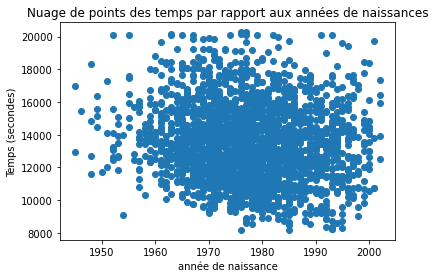

In [24]:
plt.xlabel("année de naissance")
plt.ylabel('Temps (secondes)')
plt.title("Nuage de points des temps par rapport aux années de naissances")
plt.scatter(x,y)

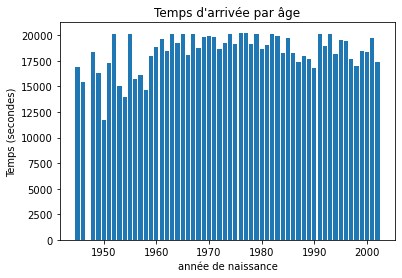

In [25]:
plt.bar(x, y)
plt.xlabel("année de naissance")
plt.ylabel('Temps (secondes)')
plt.title("Temps d'arrivée par âge")
plt.show()

On essaye maintenant de clusteriser les athlètes dans ce nuages afin d'analyser la possibilité de groupe de niveau selon l'âge. Il se pourrait qu'il y ait des groupes car la démocritasition du sport, à travers par exemples des Jeux Olympiques, peut inciter une génration précise à se lancer dans le sport. Ces évènements créent des point de rupture dans la performance entre les générations. 

On peut utiliser l'indice de silhouette pour évaluer la qualité des clusters. Cet indice mesure la distance entre les points d'un cluster et la moyenne de tous les autres clusters, ce qui permet de déterminer si les points d'un cluster sont bien regroupés ou s'ils sont dispersés. Plus l'indice de silhouette est élevé, mieux c'est.

Avec cet indice, on peut trouver le nombre de clusters qui donne les meilleures performances en termes de qualité des clusters.

In [26]:
data_cluster=np.dstack((x,y))[0]

In [27]:
# Nombre de cluster à tester :
num_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Méthode KMeans en spécifiant différents nombres de clusters
for n in num_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(data_cluster)
    
    # Utilisation de l'indice de silhouette pour évaluer la qualité des clusters
    silhouette_avg = metrics.silhouette_score(data_cluster, kmeans.labels_)
    print("Pour n_clusters =", n, "Le score de silhouette moyen est :", silhouette_avg)

Pour n_clusters = 2 Le score de silhouette moyen est : 0.5600082916609319
Pour n_clusters = 3 Le score de silhouette moyen est : 0.5468755123031502
Pour n_clusters = 4 Le score de silhouette moyen est : 0.5294005259643976
Pour n_clusters = 5 Le score de silhouette moyen est : 0.5474257836243129
Pour n_clusters = 6 Le score de silhouette moyen est : 0.5491333176605266
Pour n_clusters = 7 Le score de silhouette moyen est : 0.5487246656914384
Pour n_clusters = 8 Le score de silhouette moyen est : 0.5495591711216165
Pour n_clusters = 9 Le score de silhouette moyen est : 0.545092727516589
Pour n_clusters = 10 Le score de silhouette moyen est : 0.5544928266779623


On teste le modèle avec 2 et 5 clusters.

In [28]:
model = KMeans(2).fit(data_cluster)

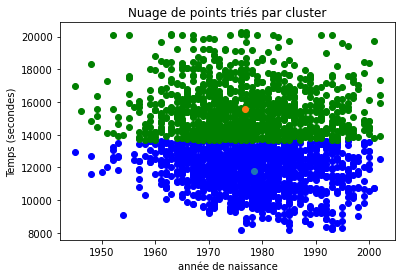

In [29]:
for point in data_cluster:
    if model.predict(point.reshape(1,-1)) == [0]:
        plt.scatter(point[0], point[1], c='b')
    elif model.predict(point.reshape(1,-1)) == [1]:
        plt.scatter(point[0], point[1], c='g')

     
for center in model.cluster_centers_:
    plt.scatter(center[0],center[1])
    plt.xlabel("année de naissance")
    plt.ylabel('Temps (secondes)')
    plt.title("Nuage de points triés par cluster")

plt.show()

In [32]:
model = KMeans(5).fit(data_cluster)

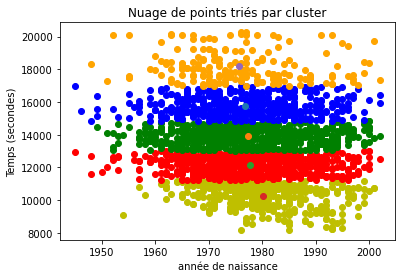

In [33]:
for point in data_cluster:
    if model.predict(point.reshape(1,-1)) == [0]:
        plt.scatter(point[0], point[1], c='b')
    elif model.predict(point.reshape(1,-1)) == [1]:
        plt.scatter(point[0], point[1], c='g')
    elif model.predict(point.reshape(1,-1)) == [2]:
        plt.scatter(point[0], point[1], c='r')
    elif model.predict(point.reshape(1,-1)) == [3]:
        plt.scatter(point[0], point[1], c='y')
    elif model.predict(point.reshape(1,-1)) == [4]:
        plt.scatter(point[0], point[1], c='orange')
     
for center in model.cluster_centers_:
    plt.scatter(center[0],center[1])
    plt.xlabel("année de naissance")
    plt.ylabel('Temps (secondes)')
    plt.title("Nuage de points triés par cluster")

plt.show()

A travers cette analyse de cluster on ne retrouve pas de différence notable d'âge entre cluster visuellement. On peut voir les centroïde de chaque cluster (affiché dans une couleur différente de celle du cluster). Les 2 clusters extrêmes montrent quand même une différence de 4 années.

In [34]:
pd.DataFrame(model.cluster_centers_, columns=(['Naissance','temps']))

,Naissance,temps
0,1976.724880,15748.566986
1,1977.323855,13893.617694
2,1977.802862,12150.434022
3,1980.069231,10240.138462
4,1975.566667,18192.050000


Testons si une régression linéaire prédit un effet de l'âge sur le résultat.

In [35]:
X = add_constant(x)
regression = OLS(y, X).fit() 

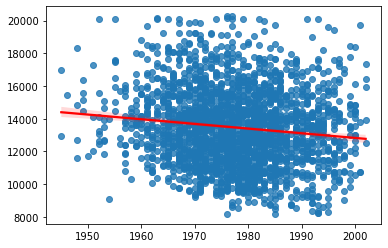

In [36]:
# Tracer un nuage de points avec la droite de régression
sns.regplot(x=x, y=y, line_kws={"color": "red"})
plt.show()

In [37]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     35.50
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           2.96e-09
Time:                        14:59:53   Log-Likelihood:                -20626.
No. Observations:                2250   AIC:                         4.126e+04
Df Residuals:                    2248   BIC:                         4.127e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        6.99e+04   9473.582      7.379      0.000    5.13e+04    8.85e+04
x1           -28.5388      4.790     -5.958      0.000     -37.932     -19.145
==============================================================================
Omnibus:                       55.908   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.770
Skew:                           0.385   Prob(JB):                     1.73e-13
Kurtosis:                       2.814   Cond. No.                     3.83e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.83e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Vérifions ex-post les hypothèses de Gauss-Markov:

1. Le coefficient de 'Naissance' est statistiquement significatif et on peut penser visuellement que l'hypothèse de linéarité est respectée. 
2. Les erreurs ne suivent pas une loi normale au seuil de confiance de 1 % selon la statistique de Jarque-Bera.
3. D'après le nuage de point, la variance des erreurs semble ne pas être constante. Les points sont moins dispersés aux extrémités. Cependant, il se pourrait que la variance soit constante sur la majorité des données hors des extrémités.
4. Il est généralement recommandé de considérer que l'hypothèse d'indépendance des erreurs est vérifiée lorsque la valeur de Durbin-Watson est comprise entre 1,5 et 2,5. Elle en est trés éloigné ici. L'hypothèse d'indépendance des erreurs est donc rejetée.

La régression n'est pas satisfaisante (R^2 très faible et coefficient non significatif) et les hypothèses de Gauss-Markov ne sont pas toute satisfaites.

On décide d'explorer l'ajout d'une variable 'sexe' dans la régression. Pour cela on utilise qui permet de prédire le sexe à partir du prénom sur la base de la fréquence.

In [38]:
detector = gender.Detector()
data1['sexe'] = data1['Prénom'].apply(lambda x : detector.get_gender(x))

/var/folders/jy/77k463fj5d94h9zj3_qn_glh0000gn/T/ipykernel_19802/2268296726.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['sexe'] = data1['Prénom'].apply(lambda x : detector.get_gender(x))


Certains prénoms sont inconnus, peut-être à cause de soucis d'accent ou bien à cause de la base utilisée pour détecter. On se concentrera dans l'analyse sur les individus dont le sexe est soit 'male', soit 'female', c'est à dire ceux dont le sexe a une probabilité importante d'être correctement prédit.

In [39]:
data2=data1[(data1['sexe']=='male') | (data1['sexe']=='female')]

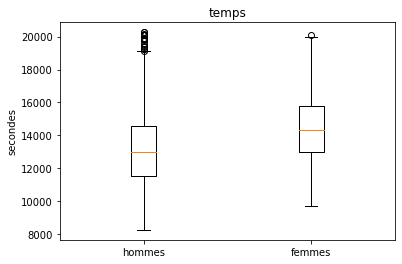

In [40]:
plt.boxplot([data2['duration'][data2['sexe']=='male'], data2['duration'][data2['sexe']=='female']], labels=['hommes', 'femmes'])
plt.title('temps')
plt.ylabel('secondes')
plt.show()

Ce box plot montre une différence de performance entre hommes et femmes.

On remplace la variable binaire par 0 et 1 afin de l'intégrer dans la régression.

In [42]:
data2['sexe'] = data2['sexe'].replace({'male': 0, 'female': 1})

/var/folders/jy/77k463fj5d94h9zj3_qn_glh0000gn/T/ipykernel_19802/3329326968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['sexe'] = data2['sexe'].replace({'male': 0, 'female': 1})


On définit maintenant les variables explicatives.

In [43]:
X=data2[['sexe','Naissance']]
X['constante']=1
X=X.to_numpy()
y=data2['duration'].to_numpy()

/var/folders/jy/77k463fj5d94h9zj3_qn_glh0000gn/T/ipykernel_19802/3850635830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['constante']=1


In [44]:
regression = OLS(y, X).fit() 

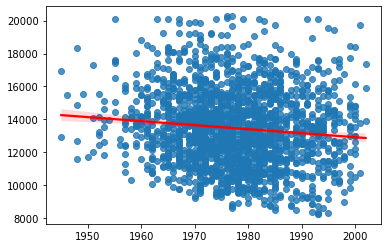

In [45]:
sns.regplot(x=data2['Naissance'].to_numpy(), y=y, line_kws={"color": "red"})
plt.show()

In [46]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     57.01
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           9.55e-25
Time:                        15:02:15   Log-Likelihood:                -16826.
No. Observations:                1840   AIC:                         3.366e+04
Df Residuals:                    1837   BIC:                         3.367e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1265.8912    132.120      9.581      0.000    1006.770    1525.013
x2           -21.2527      5.183     -4.101      0.000     -31.417     -11.088
const       5.524e+04   1.03e+04      5.388      0.000    3.51e+04    7.53e+04
==============================================================================
Omnibus:                       56.557   Durbin-Watson:                   0.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.393
Skew:                           0.447   Prob(JB):                     4.66e-14
Kurtosis:                       2.958   Cond. No.                     3.84e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.84e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

L'ajout de sexe comme variable explicative semble être utile pour expliquer le temps d'arrivée des athlètes car le R^2 a augmenté. Les coefficients des variables 'sexe' et 'Naissance' sont de plus tous les deux statistiquement significatif. Etre une femme prédit un temps d'arrivée d'environ 21 minutes plus long toute chose égale par ailleurs. De plus, être né une année plus tard prédit une performance d'environ 21 secondes meilleures.

Le coefficient estimé de la variable 'Naissance' a augmenté dans ce second modèle. Il se pourrait donc qu'il y ait un biais d'ommission lié à la variable 'sexe' dans le premier modèle. C'est le cas si le sexe et l'âge sont liés. A priori ces deux variables sont indépendantes. Toutefois, il se pourrait que les femmes se soient intégrées dans l'athlètisme plus récemment que les hommes. Il pourrait y avoir alors une moyenne d'âge plus jeune chez les femmes que chez les hommes et donc un biais d'omission. Ce n'est pas le cas dans ce jeu de données où les femmes sont en moyenne légèrement plus agées que les hommes.

In [153]:
data2.Naissance[(data2['sexe']==0)].mean()

1978.025850340136

In [154]:
data2.Naissance[(data2['sexe']==1)].mean()

1976.4216216216216